# Function for plotting oban

Note: This script is not functional yet. This is just for testing to prep for the final .py file that is used with realtime files

In [1]:
import cartopy.crs as ccrs 
import cartopy.feature as cfeature
from metpy.plots import USCOUNTIES

import datetime as dt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.axes as maxes

from netCDF4 import num2date
import numpy as np
import glob
import SNmods as snmods

import pandas as pd
from info import probe_locs, savedir
from functions import calc_dewpoint,calc_thetae,calc_thetav,C_to_F,calc_mslp,convert_wind, parse_currtime
from functions_plotting import scale_bar, plot_logo, min_col, make_cmap, drop_nans_wind, drop_nans_var
from metpy.interpolate import interpolate_to_grid
from collections import OrderedDict
import cmocean


# # read in cartopy information    
crs = ccrs.PlateCarree()
# Get data to plot state and province boundaries
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lakes',
        scale='10m',
        facecolor='none')


tv_cmap = min_col(cmocean.cm.deep, minval=0., maxval=0.85, n=40)
tv_grad_cmap = make_cmap(['#ffffff','#aad5e2','#3589a5','#072f3d'][::-1])

%config InlineBackend.figure_format='retina'


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [8]:
def get_gradTV(analysis_time, probes, merge=np.asarray([None])):
    ''' 
    Calculates current and 6-hourly max thetav gradient'''
    
    endtime = analysis_time #dt.datetime.utcnow()
    starttime = endtime - dt.timedelta(hours=6)

    df_grad = pd.DataFrame()
    for p in probes:

        df = snmods.get_sticknet_data(starttime,endtime, dataset='subset', returndata=True,probes=[p]);
        # calculate thetav grad
        temp_c = df['T'].values
        dewp_c = calc_dewpoint(temp_c,df['RH'].values)
        thetav = calc_thetav(temp_c,dewp_c, df['P'].values)

        df['TVgrad'] = np.nan
        df.loc[df.index[0]+dt.timedelta(minutes=1):,'TVgrad'] = thetav[1:]-thetav[:-1]

        TVgrad_6hrly = np.round(df['TVgrad'].min(),2)
        TVgrad_current = np.round(df['TVgrad'].values[-1],2)

        temp_df = pd.DataFrame(data={'TVgrad_6hr':TVgrad_6hrly, 'TVgrad':TVgrad_current}, index=[df.attrs['probe']])

        df_grad = df_grad.append(temp_df)

    df_grad.sort_index(ascending=True, inplace=True) 
    
    if merge.any != None: # merge into existing data frame
        df_grad = df_grad.merge(merge, how='right', left_index=True, right_on=merge.index)
        df_grad.drop(columns='key_0', inplace=True)
        df_grad.attrs = {'units': merge.attrs['units']+', gradTV(K/min)'}
    
    return df_grad 



def plot_oban(lats, lons, variable, u,v, levels=[], cmap='viridis', 
              alpha=1, cbar_label='', obtime=dt.datetime(1970,1,1,0),
             name='variable'):
    
    ''' 
    Makes a 2D interpolation of StesoNet data with wind barbs onto a cartopy map. 
    Uses Natural Neighbor interpolation from metpy.
    Figure geographic area and colorbar size will change dependent on location and distance
    between sticknets. 
    
    INPUTS:
    lats:      array or list of StesoNet latitude locations
    lons:      array or list of StesoNet longitude locations
    variable:  array or list of data to be interpolated (i.e., temperature, dewpoint, etc. )
    u, v:      u and v components of the wind, from "convert_wind" function
    levels:    contour levels
    cmap:      colormap
    alpha:     opaqueness of colormap
    cbar_label:name of the variable and the units
    obtime:    Time of data used on plot, may be different than name of figure
    name:      name of the saved figure. Figname will be name_oban_currenttime.png
     
    Developed 2021 by J. McDonald
    '''
    
    
    ### find extent of plot
    # exact center of plot
    clat = np.amin(lats)+ abs(np.amax(lats) - np.amin(lats))/2
    clon = np.amin(lons) + abs(np.amin(lons) - np.amax(lons))/2

    # NOTE: change these hardcoded values if you want to change relative domain size
    # larger (smaller) numbers = larger (smaller) domain
    dlat = 0.70 * abs(np.amax(lats) - np.amin(lats))
    dlon = 0.65 * abs(np.amin(lons) - np.amax(lons))
    
    if dlon < .1:
        dlon = .1
    if dlat < .1:
        dlat = .1

    # find corners using the center and the buffers
    north_lat, south_lat = clat+dlat, clat-dlat
    west_lon, east_lon = clon-dlon, clon+dlon


    ### initialize figure
    fig = plt.figure(figsize = [10,10])
    ax = fig.add_subplot(1,1,1, projection=crs)
    ax.set_extent([west_lon, east_lon, north_lat,south_lat], crs )
    ax.add_feature(states_provinces, edgecolor='k', alpha=0.25, linewidth=2)
    ax.add_feature(USCOUNTIES.with_scale('20m'), alpha=0.4, linewidth=0.2)

    ### interpolate data. Hres is 0.05 degrees 
    # drop nans so that you don't lose a huge chunk of grid during interpolation
    varn, latsn, lonsn, FLAG = drop_nans_var(variable, lats, lons)
    gx,gy,img1 = interpolate_to_grid(np.asarray(lonsn),np.asarray(latsn),np.asarray(varn),\
                         interp_type='natural_neighbor',hres=.05)

    ### plot data
    calpha = alpha+0.1
    if calpha >1:
        calpha=1
    ax.contour(gx, gy, img1, cmap=cmap, levels=levels, alpha=calpha, linewidths=1.5)
    im = ax.contourf(gx, gy, img1, cmap=cmap, levels=levels, alpha=alpha, antialiased=True, extend='both')
    
    ### set colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="5%", pad=0.1, axes_class=maxes.Axes)
    cbar = plt.colorbar(im, cax=cax, orientation='horizontal')
    cbar.set_label(label=cbar_label, size=16, weight='bold', labelpad=12)
    cbar.ax.tick_params(labelsize=15)


    ### wind barbs
    # drop nans so that you don't lose a huge chunk of grid during interpolation
    un, vn, latsn, lonsn = drop_nans_wind(u,v,lats,lons)
    bx,by,U = interpolate_to_grid(np.asarray(lonsn),np.asarray(latsn),np.asarray(un),\
                         interp_type='natural_neighbor',hres=.05)
    _,_,V = interpolate_to_grid(np.asarray(lonsn),np.asarray(latsn),np.asarray(vn),\
                         interp_type='natural_neighbor',hres=.05)

    ### handle skips
    if np.shape(bx)[0] * np.shape(bx)[1] > 900:
        skip =3
    else:
        skip=2
    ax.barbs(bx[::skip,::skip], by[::skip,::skip], U[::skip,::skip], V[::skip,::skip],
            length=7.5,sizes={'emptybarb':.1}, lw=0.8,zorder=10)


    ### title
    ax.set_title('Objective Analysis at {}'.format(obtime.strftime('%D %H:%M UTC')),
                 fontsize=18, y=1.01, weight='bold', color='0.3')
        

    ### Plot the TTU logo
    plt.draw()
    plot_logo(fig, ax)

    
    ### Scale Bar
    center = np.average([ax.get_position().x0, ax.get_position().x1])
    scale_len = np.ceil((dlon*10)/3.5)*10
    if scale_len < 10: scale_len = 10
    scale_bar(fig, ax, length=int(scale_len), location=(center, ax.get_position().y0),fontsize=10)
    
    ## warn if variable data is missing!
    if FLAG != 0:
        plt.draw()
        ax.text(center,0.98,  f'{FLAG} StickNets missing, plot may be inaccurate', 
                fontsize=10,color='r',ha='center', va='center', transform=ax.transAxes)
    
    
    # save figure 
    savedir = 'RT_tests/20170430' # hard coded real time directory
    #nametime = parse_currtime()[1] # note that this may be different from last time on plot
                                 # THATS OKAY... it will make data drops more apparent!
    nametime = obtime.strftime('%Y%m%d_%H%M')    
    plt.savefig('{0}/{1}_oban_{2}.png'.format(savedir,name,nametime),dpi=300,bbox_inches = 'tight')
    plt.close()


    #plt.show()



/Users/jessmcd/miniconda3/envs/py3_cart/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
start = dt.datetime(2017,4,30,18,)
end = dt.datetime(2017,4,30,18,30)
step = dt.timedelta(minutes=5)

probes = list(probe_locs.keys())

for t in np.arange(start, end+step, step):
    t = t.astype(dt.datetime)
    data_df = snmods.get_sticknet_data(t,t, dataset='latest', probes = probes)

    # can only create oban plots if there's enough available data
    if len(data_df) >= 4:
        data_df = get_gradTV(t, probes, merge=data_df);

        obtime = data_df['date'][0]

        # # pull sticknet locations 
        lats =       data_df['Lat'].values
        lons =       data_df['Lon'].values
        elevations = data_df['Elevation'].values

        # calculate variables
        temp_c = data_df['T'].values
        dewp_c = calc_dewpoint(temp_c,data_df['RH'].values)
        thetae = calc_thetae(temp_c,dewp_c, data_df['P'].values)
        thetav = calc_thetav(temp_c,dewp_c, data_df['P'].values)
        u,v = convert_wind((data_df['WS'].values), data_df['WD'].values)
        mslp = calc_mslp(temp_c, data_df['P'].values, elevations)


        # # PLOT ALL THE THINGS!
        plot_oban(lats, lons, data_df['TVgrad_6hr'].values,u,v, levels=np.arange(-2.8,.2, 0.1), cmap=tv_grad_cmap, alpha=.9,
                  cbar_label=r'Min 6-hourly ${\mathbf{\Delta\theta_v}}$ (K/min)', obtime=obtime, name='gradTV_6hr')

        plot_oban(lats, lons, data_df['TVgrad'].values,u,v, levels=np.arange(-.8,.2, 0.1), cmap=tv_grad_cmap, alpha=.9,
                  cbar_label=r'${\mathbf{\Delta\theta_v}}$ (K/min)', obtime=obtime, name='gradTV')

/Users/jessmcd/miniconda3/envs/py3_cart/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0102A
0103A
0104A
0105A
0106A
0107A
0108A
0109A
0110A
0111A
0112A
0213A
0214A
0215A
0216A
0217A
0102A
0103A
0104A
0105A
0106A
0107A
0108A
0109A
0110A
0111A
0112A
0213A
0214A
0215A
0216A
0217A
0102A
0103A
0104A
0105A
0106A
0107A
0108A
0109A
0110A
0111A
0112A
0213A
0214A
0215A
0216A
0217A
0102A
0103A
0104A
0105A
0106A
0107A
0108A
0109A
0110A
0111A
0112A
0213A
0214A
0215A
0216A
0217A
0102A
0103A
0104A
0105A
0106A
0107A
0108A
0109A
0110A
0111A
0112A
0213A
0214A
0215A
0216A
0217A
0102A
0103A
0104A
0105A
0106A
0107A
0108A
0109A
0110A
0111A
0112A
0213A
0214A
0215A
0216A
0217A
0102A
0103A
0104A
0105A
0106A
0107A
0108A
0109A
0110A
0111A
0112A
0213A
0214A
0215A
0216A
0217A
0102A
0103A
0104A
0105A
0106A
0107A
0108A
0109A
0110A
0111A
0112A
0213A
0214A
0215A
0216A
0217A
0102A
0103A
0104A
0105A
0106A
0107A
0108A
0109A
0110A
0111A
0112A
0213A
0214A
0215A
0216A
0217A
0102A
0103A
0104A
0105A
0106A
0107A
0108A
0109A
0110A
0111A
0112A
0213A
0214A
0215A
0216A
0217A
0102A
0103A
0104A
0105A
0106A
0107A
0108

In [ ]:
analysis_time = dt.datetime(2017,4,30,19,9) #dt.datetime.utcnow()
probes = list(probe_locs.keys())

# # pull StickNet data we want to plot
data_df = snmods.get_sticknet_data(analysis_time, analysis_time, dataset='latest', probes = probes)

# can only create oban plots if there's enough available data
if len(data_df) >= 4:
    data_df = get_gradTV(analysis_time, probes, merge=data_df);

    obtime = data_df['date'][0]

    # # pull sticknet locations 
    lats =       data_df['Lat'].values
    lons =       data_df['Lon'].values
    elevations = data_df['Elevation'].values

    # calculate variables
    temp_c = data_df['T'].values
    dewp_c = calc_dewpoint(temp_c,data_df['RH'].values)
    thetae = calc_thetae(temp_c,dewp_c, data_df['P'].values)
    thetav = calc_thetav(temp_c,dewp_c, data_df['P'].values)
    u,v = convert_wind((data_df['WS'].values), data_df['WD'].values)
    mslp = calc_mslp(temp_c, data_df['P'].values, elevations)


    # # PLOT ALL THE THINGS!
    plot_oban(lats, lons, data_df['TVgrad_6hr'].values,u,v, levels=np.arange(-2.8,.2, 0.1), cmap=tv_grad_cmap, alpha=.9,
              cbar_label=r'Min 6-hourly ${\mathbf{\Delta\theta_v}}$ (K/min)', obtime=obtime, name='gradTV_6hr')

    plot_oban(lats, lons, data_df['TVgrad'].values,u,v, levels=np.arange(-.8,.2, 0.1), cmap=tv_grad_cmap, alpha=.9,
              cbar_label=r'${\mathbf{\Delta\theta_v}}$ (K/min)', obtime=obtime, name='gradTV')

/Users/jessmcd/miniconda3/envs/py3_cart/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0102A
0103A
0104A
0105A
0106A
0107A
0108A
0109A
0110A
0111A
0112A
0213A
0214A
0215A
0216A
0217A
0102A
0103A
0104A
0105A
0106A
0107A
0108A
0109A
0110A
0111A
0112A
0213A
0214A
0215A
0216A
0217A


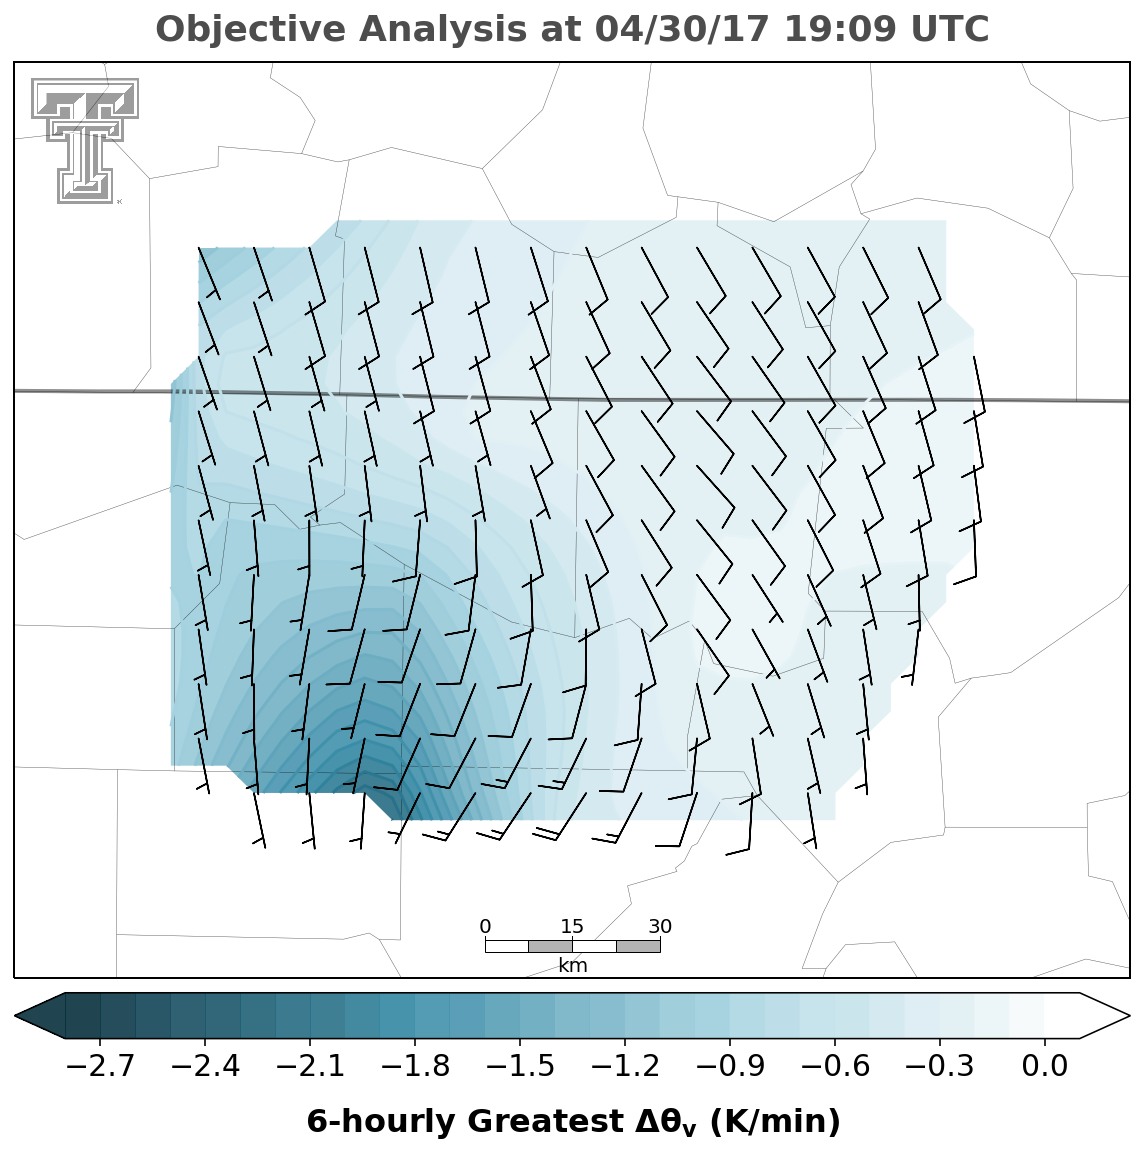

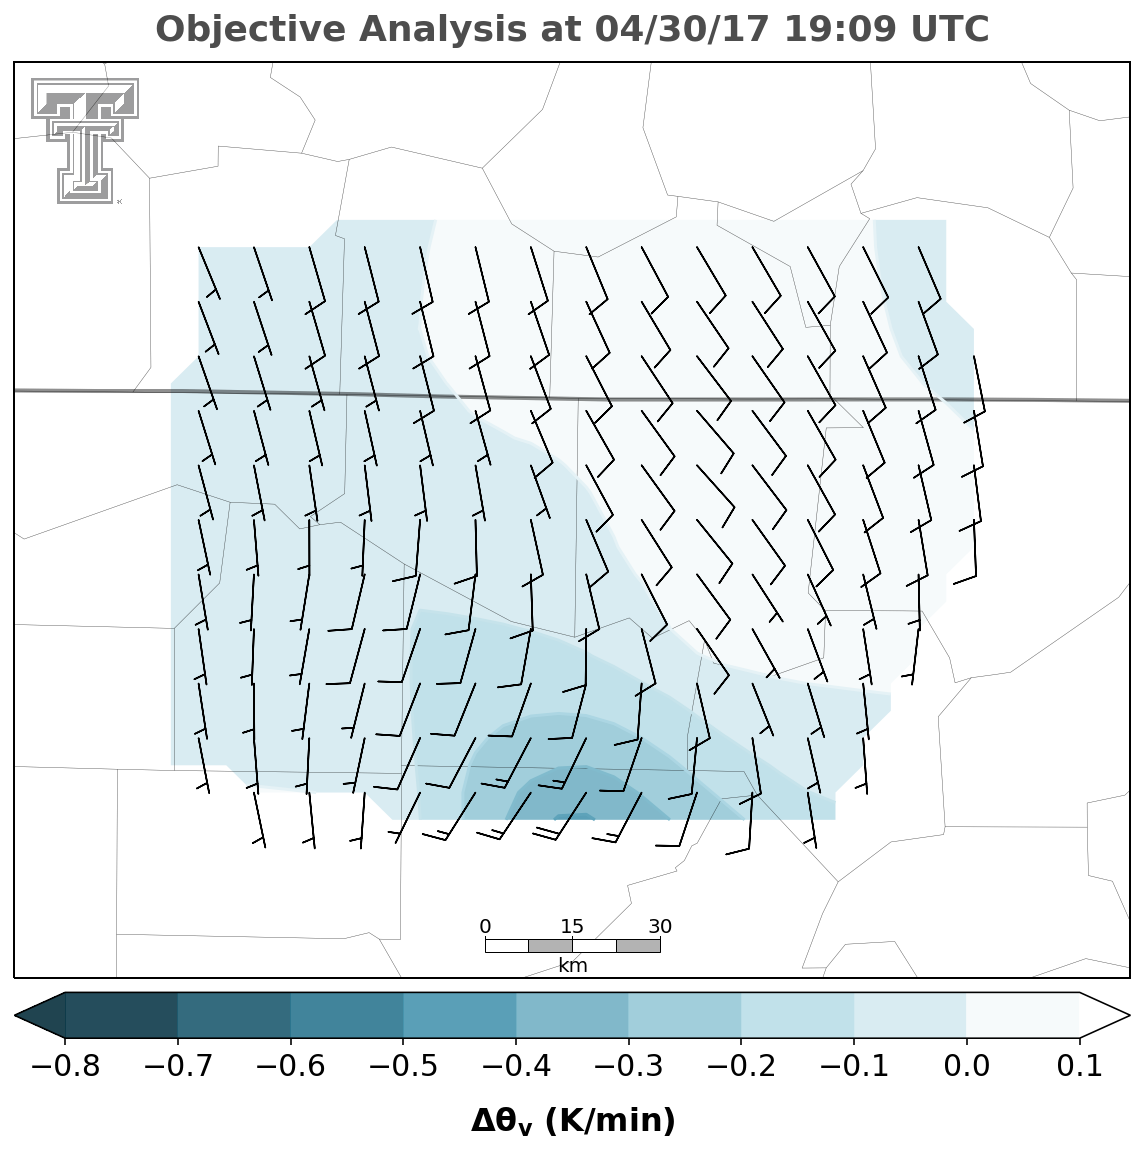

In [8]:

# get data
analysis_time = dt.datetime(2017,4,30,19,9) #dt.datetime.utcnow()
probes = list(probe_locs.keys())

# # pull StickNet data we want to plot
data_df = snmods.get_sticknet_data(analysis_time, analysis_time, dataset='latest', probes = probes)

# can only create oban plots if there's enough available data
if len(data_df) >= 4:
    data_df = get_gradTV(analysis_time, probes, merge=data_df);

    obtime = data_df['date'][0]

    # # pull sticknet locations 
    lats =       data_df['Lat'].values
    lons =       data_df['Lon'].values
    elevations = data_df['Elevation'].values

    # calculate variables
    temp_c = data_df['T'].values
    dewp_c = calc_dewpoint(temp_c,data_df['RH'].values)
    thetae = calc_thetae(temp_c,dewp_c, data_df['P'].values)
    thetav = calc_thetav(temp_c,dewp_c, data_df['P'].values)
    u,v = convert_wind((data_df['WS'].values), data_df['WD'].values)
    mslp = calc_mslp(temp_c, data_df['P'].values, elevations)


    # # PLOT ALL THE THINGS!
    plot_oban(lats, lons, data_df['TVgrad_6hr'].values,u,v, levels=np.arange(-2.8,.2, 0.1), cmap=tv_grad_cmap, alpha=.9,
              cbar_label=r'Min 6-hourly ${\mathbf{\Delta\theta_v}}$ (K/min)', obtime=obtime, name='gradTV_6hr')

    plot_oban(lats, lons, data_df['TVgrad'].values,u,v, levels=np.arange(-.8,.2, 0.1), cmap=tv_grad_cmap, alpha=.9,
              cbar_label=r'${\mathbf{\Delta\theta_v}}$ (K/min)', obtime=obtime, name='gradTV')

    # temp
    # plot_oban(lats, lons, temp_c,u,v, levels=np.arange(0,37,1), cmap='cmo.amp', alpha=0.7,
    #           cbar_label='Temperature (C)', obtime=obtime, name='temp')
    # # dewpoint
    # plot_oban(lats, lons, dewp_c,u,v, levels=np.arange(0,37,1), cmap='cmo.speed', alpha=0.6,
    #           cbar_label='Dewpoint (C)', obtime=obtime, name='dewp')
    # # mslp
    # plot_oban(lats, lons, mslp, u,v,levels=np.arange(990, 1029, 2), cmap='cmo.matter', alpha=0.7,
    #           cbar_label='Mean Sea Level Pressure (hPa)', obtime=obtime, name='mslp')
    # # thetav
    # plot_oban(lats, lons, thetav,u,v, levels=np.arange(280,307,1), cmap=tv_cmap, alpha=0.9,
    #           cbar_label='Virtual Potential Temperature (K)', obtime=obtime, name='thetav')
    # # thetae
    # plot_oban(lats, lons, thetae,u,v, levels=np.arange(310,351,2), cmap='cmo.rain', alpha=0.7,
    #           cbar_label='Psuedoequivalent Potential Temperature (K)', obtime=obtime, name='thetae') 

## Testing with meso18-19 data

In [3]:
# test with meso18-19 data

crs = ccrs.PlateCarree()
# Get data to plot state and province boundaries
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lakes',
        scale='10m',
        facecolor='none')
    
def get_stesonet(time):
    ''' 
    Returns all available sticknets at a give time.
    -------------
    INPUT: a datetime object specifying the time of interest
    OUTPUT: a pandas dataframe containing all available sticknet data.
    -------------
    Note: manually edit datadir.
    Note: "3secmax" is the maximum mean 3-second wind gust.
    '''
    date = time.strftime('%Y%m%d')
    datadir = r'/Users/jessmcd/Documents/MyPassport_backup/Meso18_19/dailyfiles/daily_files_1min_mean/*_{}.txt'.format(date)
    files = sorted(glob.glob(datadir), key=lambda f: f[-18:-13]) # put files in order by SN ID

    # initialize empy dataframes/arrays
    df = pd.DataFrame(data={})
    ids=[]
    
    # loop over all files
    for f in files:
        data = pd.read_csv(f, header=0, names=['time','T','RH','P','WS','3secmax','WD','batt','tflag','wflag'],
                      dtype={'time':np.str}, index_col=0, infer_datetime_format=True)
        data.index = pd.to_datetime(data.index)
        try:
            temp = data.loc[time]

            if temp.empty != True:
                temp.drop(labels=['3secmax', 'batt', 'tflag', 'wflag'], inplace=True)
                df = df.append(temp)
                ids.append(f[-18:-13])
        except KeyError:
            continue
    
    # set index to be IDs since we already know what time it should be
    df.index = ids
    df.insert(0, "probe", ids, True)
    
    print('Found {} StickNets'.format(len(ids)))
    return df

probe_locs = probe_info.probe_locs_2019 
probes = np.arange(1,24,1)

date = dt.datetime(2019,3,14,23,50)
data_df = get_stesonet(date)


obtime = date#data_df['dates'][0]

# # pull sticknet locations
lats,lons, elevations = [],[],[]
for count,loc in enumerate(data_df['probe']):
    lats.append(probe_locs[loc][0])
    lons.append(probe_locs[loc][1])
    elevations.append(probe_locs[loc][2])

# calculate variables
temp_c = data_df['T']
dewp_c = calc_dewpoint(data_df['T'].values,data_df['RH'].values)
thetae = calc_thetae(data_df['T'].values,dewp_c, data_df['P'].values)
thetav = calc_thetav(data_df['T'].values,dewp_c, data_df['P'].values)

# mslp can't handle an array for elevations, so put in a loop
mslp = []
for i in range(0,len(probes)+1):
    mslp.append(calc_mslp(data_df['T'][i],data_df['P'][i], elevations[i]))


u,v = convert_wind(data_df['WS'].values, data_df['WD'].values)

Found 24 StickNets


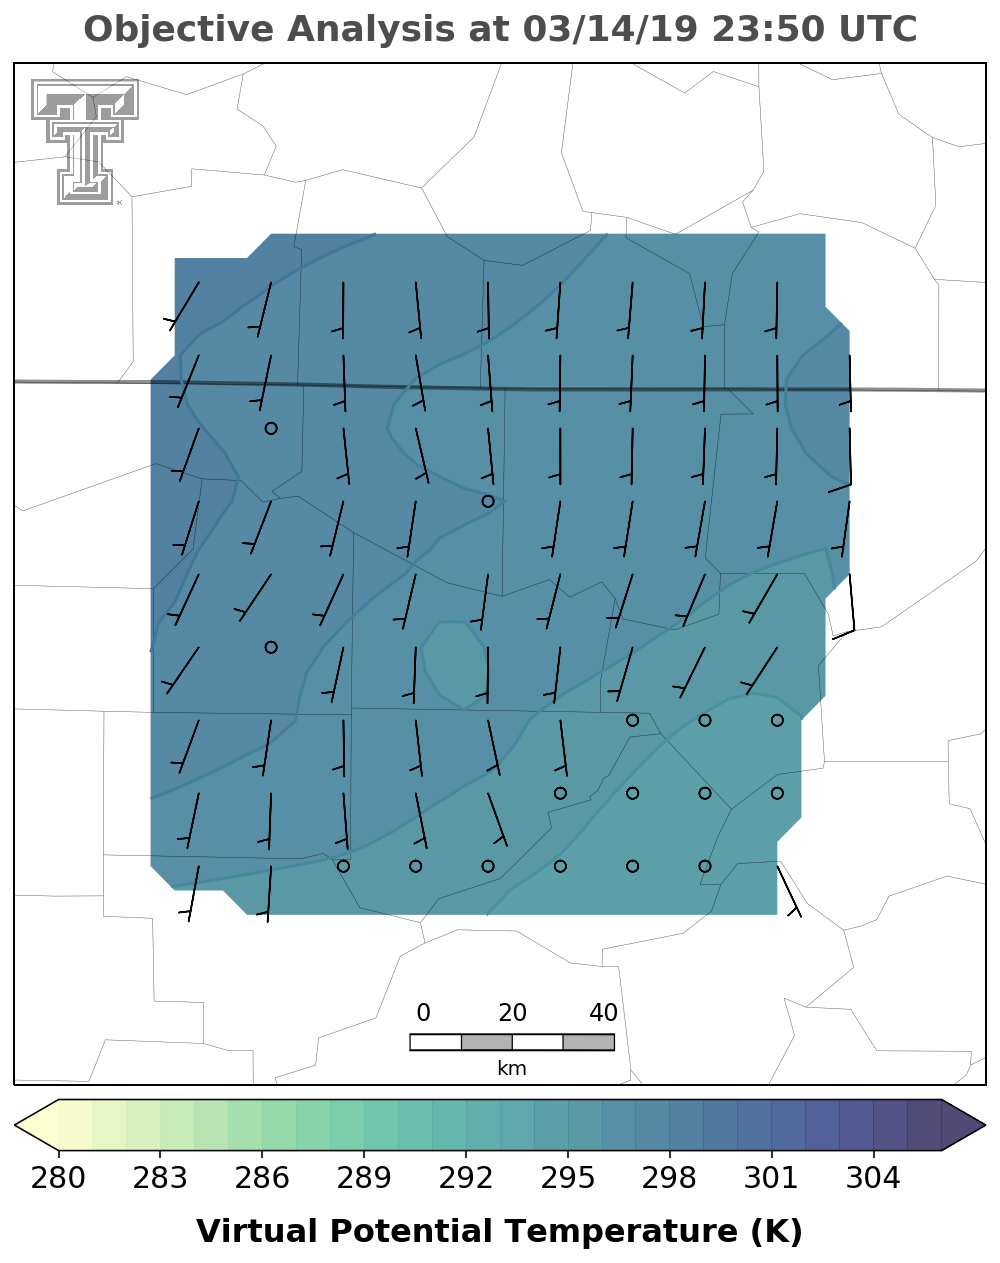

In [4]:
tv_cmap = min_col(cmocean.cm.deep, minval=0., maxval=0.85, n=40)

# plot_oban(lats, lons, temp_c, u,v,levels=np.arange(0,37,1), cmap='cmo.amp', alpha=0.7,
#           cbar_label='Temperature (C)', obtime=obtime, name='temp')

# plot_oban(lats, lons, dewp_c, u,v,levels=np.arange(0,37,1), cmap='cmo.speed', alpha=0.6,
#           cbar_label='Dewpoint (C)', obtime=obtime, name='dewp')

# plot_oban(lats, lons, mslp, u,v,levels=np.arange(990, 1029, 2), cmap='cmo.matter', alpha=0.7,
#           cbar_label='Mean Sea Level Pressure (hPa)', obtime=obtime, name='mslp')

plot_oban(lats, lons, thetav,u,v, levels=np.arange(280,307,1), cmap=tv_cmap, alpha=0.9,
          cbar_label='Virtual Potential Temperature (K)', obtime=obtime, name='thetav')

# plot_oban(lats, lons, thetae, u,v,levels=np.arange(310,351,2), cmap='cmo.rain', alpha=0.7,
#           cbar_label='Psuedoequivalent Potential Temperature (K)', obtime=obtime, name='thetae') 
  

In [13]:
np.shape(bx)[0] * np.shape(bx)[0]

961